<a href="https://colab.research.google.com/github/mb26-code/ter-rel-sem/blob/main/Extraction_relations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive

import sys
import os

drive.mount('/content/gdrive')
my_local_drive='/content/gdrive/My Drive/TER/'
sys.path.append(my_local_drive)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install spacy pandas
!pip install wikipedia-api

# Téléchargement les contenus de Wiki

In [8]:
import wikipediaapi
import re
from urllib.parse import unquote

# url = "https://fr.wikipedia.org/wiki/Pot-au-feu"  # Change this to any Wikipedia URL
url = "https://fr.wikipedia.org/wiki/Tripes_%C3%A0_la_proven%C3%A7ale"

def get_wikipedia_text(url, lang='fr'):
    # Extract the title from the Wikipedia URL
    decoded_url = unquote(url)
    match = re.search(r"/wiki/(.+)$", decoded_url)
    if not match:
        print("Invalid Wikipedia URL.")
        return None

    page_title = match.group(1).replace('_', ' ')

    wiki_wiki = wikipediaapi.Wikipedia(language=lang, user_agent="MyWikipediaScraper/1.0")
    page = wiki_wiki.page(page_title)

    if not page.exists():
        print(f"Page '{page_title}' does not exist.")
        return None

    return page.text

text = get_wikipedia_text(url)

# Save to a text file
if text:
    with open(f"{my_local_drive}wikipedia_text.txt", "w", encoding="utf-8") as f:
        f.write(text)
    print(f"Text saved to wikipedia_text.txt")


Text saved to wikipedia_text.txt


In [4]:
content = ""
with open(f"{my_local_drive}wikipedia_text.txt", "r", encoding="utf-8") as f:
  content = f.read();
  # print(content)

# Traitement initial

In [5]:
!python -m spacy download fr_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 MB 1.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Explication de l'algo
Je crée une classe `TokenAnnotation` pour traiter chaque token (mot). Cette classe est pour but de stocker des infos du token lui-même, comme :
- text : texte brut
- lemma : texte après traitement
- pos : nature du mot (adj, adv, nom)
- dep : label de dépendence, pour définir sa relation avec un autre token (head) dans la phrase, comme `nsubj` --> nominal subject
- head : indice de `head` de ce token. Càd ce token est le dépendent de head

Ultérieurement, on va se baser sur cette `dep` pour filtrer quelles dépendences qu'on prendra pour tester avec l'API JdM, au lieu de brute-force tous les cas inutiles.

Par exemple, prenons cette phrase :
**Le bouillon contient traditionnellement un oignon piqué de clous de girofle, l'ail est déconseillé.**

Après l'extraction, `girofle` a son head `clou` et sa dep `nmod`.
```
head | lemma | dep
('clou', 'girofle', 'nmod')
```
Vérifions avec JdM : https://jdm-api.demo.lirmm.fr/v0/relations/from/clou/to/girofle

On aura 2 relations :

- Type 0 : r_associated
- Type 8 : r_hypo

Donc, on sauvegardera dans la BdD cette paire et ses relations, à filtrer par le poids `w` si nécessaire.

À consulter les relations types : https://jdm-api.demo.lirmm.fr/v0/relations_types#



# 1. CRÉATION DE CLASSE ET PARSING

In [13]:
from dataclasses import dataclass
from typing import List, Optional
import spacy
nlp = spacy.load("fr_core_news_lg")

@dataclass
class TokenAnnotation:
    text: str           # surface form
    lemma: str          # canonical form
    pos: str            # part-of-speech tag
    dep: str            # dependency label
    head: int           # index of the head token in its sentence
    sent_id: Optional[int] = None  # optional: which sentence

def annotate(text: str) -> List[List[TokenAnnotation]]:
    doc = nlp(text)
    all_sents: List[List[TokenAnnotation]] = []
    for sent_id, sent in enumerate(doc.sents):
        tokens = []
        for token in sent:
            tokens.append(TokenAnnotation(
                text=token.text,
                lemma=token.lemma_,
                pos=token.pos_,
                dep=token.dep_,
                head=token.head.i - sent.start,  # index *within* this sentence
                sent_id=sent_id
            ))
        all_sents.append(tokens)
    return all_sents

# Exécution
# Utiliser ça au lieu du texte brut de Wikipedia pour tester
test_text = """Le pot-au-feu (inv.) est une recette de cuisine traditionnelle emblématique historique de la cuisine française, et du repas gastronomique des Français, à base de viande de bœuf cuisant longuement à feu très doux dans un bouillon de légumes (poireau, carotte, navet, oignon, céleri, chou et bouquet garni). La présence de pommes de terre est discutée, puisqu’elles ne faisaient pas partie de la recette d’origine, la pomme de terre n’ayant été introduite en France par Antoine Parmentier qu’à la fin du XVIIIe siècle. Historiquement, c’est plutôt le panais qui jouait son rôle.
Historique
Jean Louis Schefer fait remonter le pot-au-feu au rêve néolithique, « celui du foyer, du vase d'argile, du pot mis au feu, de la soif étanchée, de la faim apaisée… », origine reprise par le restaurant À la Cloche d'or : « Pot-au-feu désigne à la base le « pot à feu », le pot dans lequel on faisait revenir un bouillon aromatique auquel on ajoutait viandes et légumes ». Jean Guillaume pense qu'à l'origine de l'agriculture les raves sont venues compléter les herbes dans les bouillons, « on y ajoutait du pain pour faire la soupe et de la viande pour les grands jours ».
Au XIIIe siècle, il est appelé « viande au pot ». Autrefois, la cuisson du pot-au-feu pouvait s’effectuer de façon continue, de nouveaux ingrédients étant rajoutés au fur et à mesure pour remplacer ceux qui étaient retirés afin d’être consommés. À présent que les maisons n’ont plus un feu de bois allumé en continu, le pot-au-feu est cuisiné spécifiquement en vue d’un repas.
Marcel Rouff, dans son roman Vie et Passion de Dodin-Bouffant, gourmet (1924) a décrit un pot-au-feu devenu mythique, qui a inspiré des pots-au-feu démesurés à de nombreux chefs.
Composition
Les coupes de bœuf et les légumes impliqués varient, mais un pot-au-feu typique contient :
des coupes de bœuf à faible coût nécessitant une longue cuisson : gîte, gîte à la noix, joue de bœuf, jarret, plat de côtes, paleron, macreuse à pot-au-feu ou jumeau à pot-au-feu ;
classiquement fait avec du bœuf ou du poulet, parfois veau, porc ou mouton sont utilisés ;
un ou plusieurs morceaux cartilagineux : queue de bœuf ou os à moelle ;
des légumes : carotte, navet, poireau, parfois pomme de terre (qui n’a été introduite que tard, au cours du XVIIIe siècle au moment de sa promotion en France par Antoine Parmentier), céleri-rave, oignon (selon les régions et les recettes) ;
des épices : bouquet garni, sel, poivre noir et clous de girofle.
Le pot-au-feu est l'un des rares plats où l'on utilise parfois des aliments brûlés : pour parfumer et colorer le bouillon, les oignons sont coupés en deux et passés au four (gril) jusqu'à ce que la surface soit complètement noire.
Jules Gouffé, cuisinier et pâtissier français du XIXe siècle distingue le petit pot-au-feu ordinaire du grand pot-au-feu des jours d'extra.
Cuisson
Deux méthodes sont en présence : mettre le bœuf dans l'eau froide ou bien dans l'eau bouillante. La première donne un bouillon succulent, la seconde préserve davantage le gout des viandes. Paul Bocuse, Jules Gouffé optent  pour l'eau froide. Un bon compromis selon Sabine Jeannin et al. est de commencer à l'eau froide avec un premier morceau de bœuf, et d'en ajouter un autre quand l'eau bout.
Le bouillon contient traditionnellement un oignon piqué de clous de girofle, l'ail est déconseillé. La cuisson doit être longue et douce, (« le premier soin est de bien faire son feu »), ébullition continue et régulière pendant 3 à 5 heures selon le contenu, trop cuire le pot-au-feu est néfaste — les légumes ne séjournent dans le bouillon que le temps de les cuire —, on laisse entrouvert le couvercle de la marmite. Le bouillon est écumé en début de cuisson puis dégraissé après avoir retiré la viande cuite. Les amateurs préfèrent le pot-au-feu réchauffé le lendemain.
Dans les autocuiseurs, la cuisson se fait toujours en deux temps, le second est bref et réservé aux légumes.
Service
Le bouillon de cuisson du pot-au-feu est servi à côté comme potage, souvent agrémenté de pâtes, riz ou pain grillé, au dîner ou en entrée avant de servir la viande et les légumes du pot-au-feu. Il sert également de base aux sauces ou à la cuisson des légumes ou des pâtes. La moelle est mangée sur du pain grillé. Ensuite, le pot-au-feu est généralement servi avec du gros sel et de la moutarde forte de Dijon. Le reste de viande peut être broyé et utilisé pour la préparation d'un pâté de viande, mais cette pratique est rare en France, sauf en Alsace où la viande et le bouillon servent à cuisiner les Fleischschnacka.
Accord mets/vin
Le vin blanc est rarement proposé avec le pot-au-feu. Il s'accorde pourtant avec ce mets s'il est ample et vif, dans ce cas, c'est un vin qui désaltère et met en appétit.
Le vin rosé à conseiller doit être sec, corsé, avec une robe rose-rouge qui témoigne de sa charge en matières sèches. Ce type de vin s'accorde avec les légumes et étanche la soif.
Le vin rouge offre une large gamme qui va des bourgognes aux bordeaux, en passant par les beaujolais, les côtes-du-rhône-villages, les coteaux-du-languedoc,."""
sents = annotate(test_text)
for sent in sents:
    print(sent)


[TokenAnnotation(text='Le', lemma='le', pos='DET', dep='det', head=1, sent_id=0), TokenAnnotation(text='pot-au-feu', lemma='pot-au-feu', pos='NOUN', dep='nsubj', head=8, sent_id=0), TokenAnnotation(text='(', lemma='(', pos='PUNCT', dep='punct', head=1, sent_id=0), TokenAnnotation(text='inv', lemma='inv', pos='NOUN', dep='appos', head=1, sent_id=0), TokenAnnotation(text='.', lemma='.', pos='PUNCT', dep='punct', head=1, sent_id=0), TokenAnnotation(text=')', lemma=')', pos='PUNCT', dep='punct', head=1, sent_id=0), TokenAnnotation(text='est', lemma='être', pos='AUX', dep='cop', head=8, sent_id=0), TokenAnnotation(text='une', lemma='un', pos='DET', dep='det', head=8, sent_id=0), TokenAnnotation(text='recette', lemma='recette', pos='NOUN', dep='ROOT', head=8, sent_id=0), TokenAnnotation(text='de', lemma='de', pos='ADP', dep='case', head=10, sent_id=0), TokenAnnotation(text='cuisine', lemma='cuisine', pos='NOUN', dep='nmod', head=8, sent_id=0), TokenAnnotation(text='traditionnelle', lemma='tr

# Voir les dépendences entre les tokens d'une phrase

In [7]:
# from spacy import displacy
# tesssst = nlp("Le bouillon contient traditionnellement un oignon piqué de clous de girofle, l'ail est déconseillé.")
# displacy.serve(tesssst, style="dep")

In [8]:
# POUR VOIR LES EXPLICATIONS DES LABELS `dep`
# for label in nlp.get_pipe("parser").labels:
#     print(label, " -- ", spacy.explain(label))


Explication des DEPS intéressés

  1.	DepLabel : nsubj
	•	Pourquoi : lie un verbe à son sujet (agent)
	•	Exemple & paire extraite : « Le pot-au-feu est une recette. » → (recette, pot-au-feu)

  2.	DepLabel : nsubj:pass
	•	Pourquoi : lie un verbe passif à son sujet/patient
	•	Exemple & paire extraite : « La présence de pomme de terre est discutée. » → (discutée, présence)

  3.	DepLabel : obj
	•	Pourquoi : lie un verbe à son objet direct (quoi fait-on ?)
	•	Exemple & paire extraite : « Schefer fait remonter le pot-au-feu. » → (remonter, pot-au-feu)

  4.	DepLabel : iobj
	•	Pourquoi : lie un verbe à son objet indirect (qui reçoit l’action)
	•	Exemple & paire extraite : « un bouillon auquel on ajoutait viandes. » → (ajoutait, auquel)

  5.	DepLabel : nmod
	•	Pourquoi : complément nominal via préposition (“de”, “à”, …)
	•	Exemple & paire extraite : « recette de cuisine » → (recette, cuisine)

  6.	DepLabel : obl
	•	Pourquoi : complément oblique (lieu, instrument, but…)
	•	Exemple & paire extraite : « cuisant à feu doux » → (cuisant, feu)

  7.	DepLabel : amod
	•	Pourquoi : lie un nom à son adjectif qualificatif
	•	Exemple & paire extraite : « recette traditionnelle » → (recette, traditionnelle)

  8.	DepLabel : compound
	•	Pourquoi : reconstitue des termes composés (expressions figées)
	•	Exemple & paire extraite : « pot-au-feu » → (pot-au-feu, feu)

  9.	DepLabel : flat:name
	•	Pourquoi : agrège des noms propres formant une seule entité
	•	Exemple & paire extraite : « Jean Louis Schefer » → (Jean, Louis)

  10.	DepLabel : appos
	•	Pourquoi : apposition — le second nom renomme le premier
	•	Exemple & paire extraite : « bouillon, poireau, carotte… » → (bouillon, poireau)

  11.	DepLabel : acl
	•	Pourquoi : clause participiale attachée à un nom
	•	Exemple & paire extraite : « pot mis au feu » → (pot, mis)

  12.	DepLabel : acl:relcl
	•	Pourquoi : proposition relative attachée à un nom
	•	Exemple & paire extraite : « le panais qui jouait son rôle » → (panais, jouait)

  13.	DepLabel : advcl
	•	Pourquoi : clause adverbiale attachée à un verbe
	•	Exemple & paire extraite : « le bouillon contient … l’ail est déconseillé » → (contient, déconseillé)

In [14]:
INTERESTING_DEPS = {
    # verbal relations: subject → verb, verb → object
    "nsubj", "nsubj:pass", "obj", "iobj",
    # noun modifiers: noun → noun (prep-headed), noun → adjective
    "nmod", "obl",  "amod",    # e.g. “recette de cuisine”, “bouillon aromatique”
    # multi-word names & appositions
    "compound", "flat:name", "appos",
    # clausal modifiers (relative/participial clauses)
    "acl", "acl:relcl", "advcl",
}

def extract_pairs(tokens):
    pairs = []
    for idx, tok in enumerate(tokens):
        if tok.dep in INTERESTING_DEPS:
            head = tokens[tok.head]               # the head token
            pairs.append(( head.lemma, tok.lemma, tok.dep ))
    return pairs

all_pairs = []
for sent in sents:
    p = extract_pairs(sent)
    all_pairs.append(p)

In [15]:
print(f"HEAD | LEMMA | DEP")
for i, pair in enumerate(all_pairs[:1]):
    for p in pair: print(p)

with open(f"{my_local_drive}pairs.txt", "w") as f:
    for i, pair in enumerate(all_pairs):
        for p in pair:
            f.write(f"{p[0]},{p[1]}\n")


HEAD | LEMMA | DEP
('recette', 'pot-au-feu', 'nsubj')
('pot-au-feu', 'inv', 'appos')
('recette', 'cuisine', 'nmod')
('cuisine', 'traditionnel', 'amod')
('cuisine', 'emblématique', 'amod')
('recette', 'historique', 'amod')
('cuisine', 'français', 'amod')
('repas', 'gastronomique', 'amod')
('repas', 'français', 'nmod')
('repas', 'base', 'nmod')
('base', 'viande', 'nmod')
('viande', 'bœuf', 'nmod')
('base', 'cuire', 'acl')
('feu', 'doux', 'amod')
('repas', 'bouillon', 'nmod')
('bouillon', 'légume', 'nmod')
('repas', 'poireau', 'appos')
('repas', 'navet', 'appos')
('bouquet', 'garni', 'amod')


# Filtrer par Word2Vec avant d'envoyer ces paires à JdM

Word2Vec :
1. Principe de base
Word2Vec encode chaque mot sous forme de vecteur en se basant sur ses contexte d’apparition (les mots voisins dans un corpus), pas sur sa forme ou sa morphologie.
2. Entraînement
-	Skip-Gram : pour un mot central w, le modèle apprend à prédire les mots qui l’entourent.
-	CBOW : pour un ensemble de mots de contexte, il prédit le mot central.
Le résultat : deux mots qui partagent des contextes similaires (ex. “girofle” et “épice”) auront des vecteurs proches.
3. Centroïde de domaine
On choisit quelques pivots représentatifs du domaine (ex. “cuisine”, “recette”, “ingrédient”) et on fait la moyenne de leurs vecteurs pour obtenir un vecteur-prototype du domaine gastronomie.

In [16]:
pairs_file = "pairs.txt"   # adjust path if needed
with open(my_local_drive + pairs_file, "r", encoding="utf-8") as f:
    candidate_pairs = [tuple(line.strip().split(","))
                       for line in f
                       if line.strip()]
print(f"Loaded {len(candidate_pairs)} candidate pairs")

Loaded 292 candidate pairs


In [17]:
# !pip install numpy==1.24.3 --force-reinstall # Downgrade numpy to a version compatible with gensim
!pip install --upgrade gensim --force-reinstall # Reinstall gensim with the compatible numpy version
# !pip install --upgrade scipy --force-reinstall

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Att

In [18]:
# Run this if model is not downloaded
!wget -c "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz" -O "cc.fr.300.vec.gz"

--2025-05-11 15:36:16--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.132.17, 18.173.132.13, 18.173.132.6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.132.17|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [19]:
import numpy as np
from gensim.models import KeyedVectors
from numpy.linalg import norm
from collections import defaultdict

model = KeyedVectors.load_word2vec_format('cc.fr.300.vec.gz', binary=False, limit=50000)  # Limit to 50k for memory

# 1. Define your gastronomy “pivot” words
pivots = ["cuisine","recette","ingrédient","épice","gastronomie"]
# Keep only those that actually exist in the model
pivot_vecs = [model[p] for p in pivots if p in model]
if not pivot_vecs:
    raise ValueError("None of your pivots were in the model!")

# 2. Compute the domain centroid
domain_centroid = np.mean(pivot_vecs, axis=0)


# 3. Load your candidate pairs (head, dependent)
#    For example, from your pairs.txt:
pairs = []
with open(f"{my_local_drive}pairs.txt", "r", encoding="utf-8") as f:
    for line in f:
        h, d = line.strip().split(",")
        pairs.append((h, d))


# 4. Define helper functions
def pair_vector(h, d):
    """Average the two word vectors."""
    return (model[h] + model[d]) / 2

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float(a.dot(b) / (norm(a) * norm(b)))


# 5. Compute similarities and filter
THRESHOLD = 0.25
filtered = []
under_threshold = []
for h, d in pairs:
    if h in model and d in model:
        vec = pair_vector(h, d)
        sim = cosine_sim(domain_centroid, vec)
        if sim >= THRESHOLD:
            filtered.append((h, d, sim))
        else:
            under_threshold.append((h, d, sim))

In [20]:
print(f"Under threshold - removed {len(under_threshold)} pairs:")
for h, d, sim in under_threshold:
    print(f"  {h:12s} {d:12s} → sim={sim:.3f}")

print("\n---------------------\n")

print(f"Kept {len(filtered)}/{len(pairs)} pairs:")
for h, d, sim in filtered:
    print(f"  {h:12s} {d:12s} → sim={sim:.3f}")


Under threshold - removed 41 pairs:
  discuter     présence     → sim=0.205
  discuter     faire        → sim=0.207
  Antoine      Parmentier   → sim=0.184
  jouer        rôle         → sim=0.243
  historique   Jean         → sim=0.127
  Jean         Louis        → sim=0.053
  cloche       or           → sim=0.201
  faire        on           → sim=0.182
  ajouter      on           → sim=0.172
  penser       Jean         → sim=0.157
  Jean         Guillaume    → sim=0.065
  ajouter      on           → sim=0.172
  ajouter      y            → sim=0.135
  appeler      il           → sim=0.147
  pouvoir      rajouter     → sim=0.239
  au           remplacer    → sim=0.076
  celui        retirer      → sim=0.247
  roman        -            → sim=0.122
  roman        1924         → sim=0.201
  coût         nécessiter   → sim=0.210
  gîte         gîte         → sim=0.236
  cours        moment       → sim=0.250
  promotion    Antoine      → sim=0.223
  Antoine      Parmentier   → sim=0.184
  ut

# Envoyer les paires récupérées ci-dessus et vérifier avec JdM

`https://jdm-api.demo.lirmm.fr/v0/relations/from/[head]/to/[lemma]`

https://jdm-api.demo.lirmm.fr/v0/relations/from/clou/to/girofle



```
{
    "nodes": [
        // On s'en fout
    ],
    "relations": [
        {
            "id": 9902807,
            "node1": 11651,
            "node2": 43873,
            "type": 0,
            "w": 55
        },
        {
            "id": 413873,
            "node1": 11651,
            "node2": 43873,
            "type": 8,
            "w": 111
        }
    ],
    "request": {
      // On s'en fout
    }
}
```



In [21]:
# prompt: Save filtered pairs to filtered_pairs.txt

with open(f"{my_local_drive}filtered_pairs.txt", "w") as f:
    for h, d, sim in filtered:
        f.write(f"{h},{d}\n")


# Get relations from JdM
Save to `relations_results.csv`.

In [22]:
import requests, csv, json, time
from tqdm import tqdm  # Import tqdm for the progress bar

BASE_URL = "https://jdm-api.demo.lirmm.fr/v0/relations"
INPUT    = f"{my_local_drive}filtered_pairs.txt"
OUTPUT   = f"{my_local_drive}relations_results.csv"

# Read and dedupe all pairs
seen = set()
unique_pairs = []
with open(INPUT, encoding="utf-8") as fin:
    for line in fin:
        head, dep = line.strip().split(",")
        pair = (head, dep)
        if pair not in seen:
            seen.add(pair)
            unique_pairs.append(pair)

# Write out results without duplicates
with open(OUTPUT, "w", newline="", encoding="utf-8") as fout:
    writer = csv.DictWriter(fout, fieldnames=["node1","node2","relations"])
    writer.writeheader()

    for head, dep in tqdm(unique_pairs, total=len(unique_pairs), desc="Processing unique pairs"):
        resp = requests.get(f"{BASE_URL}/from/{head}/to/{dep}")
        resp.raise_for_status()
        rels = resp.json().get("relations", [])
        writer.writerow({
            "node1": head,
            "node2": dep,
            "relations": json.dumps(rels, ensure_ascii=False)
        })
        time.sleep(0.2)

Processing pairs: 100%|██████████| 191/191 [01:39<00:00,  1.92it/s]


**Preview results**

 rel_type         Name           Label  Count  % of total  Mean_w
      0.0 r_associated   idée associée     34        30.4  106.74
     17.0      r_carac caractéristique     18        16.1   59.44
    666.0        r_aki           r_aki      8         7.1    3.12
      8.0       r_hypo      spécifique      7         6.2  102.71
     14.0    r_patient  action>patient      6         5.4   72.33
    106.0  r_has_color         couleur      5         4.5    9.00
     15.0       r_lieu      chose>lieu      4         3.6   34.00
     27.0   r_domain-1       domaine-1      4         3.6   26.25
    777.0       r_wiki          r_wiki      4         3.6    9.75
     10.0       r_holo            tout      3         2.7   37.67


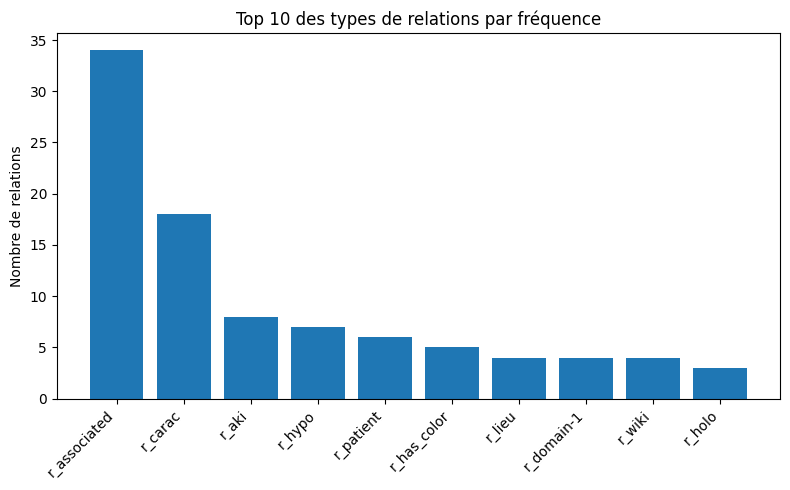

In [31]:
import pandas as pd
import json

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/content/gdrive/My Drive/TER/relations_results.csv')
import matplotlib.pyplot as plt

# ─ Assumes you already have:
#    df         = your DataFrame with columns ['node1','node2','relations']
#    rel_types  = list of dicts loaded from relations_types.json

# 1. Parse the JSON strings in 'relations'
df['relations'] = df['relations'].apply(json.loads)

# Load the CSV and JSON metadata
with open('/content/gdrive/My Drive/TER/relations_types.json', 'r', encoding='utf-8') as f:
    rel_types = json.load(f)

# 2. Explode & normalize into a flat DataFrame
rel_df = pd.json_normalize(
    df.explode('relations')['relations']
).rename(columns={'type': 'rel_type', 'w': 'weight'})

# 3. Compute aggregate stats
stats = (
    rel_df
    .groupby('rel_type', as_index=False)
    .agg(Count=('rel_type', 'size'),
         Mean_w=('weight', 'mean'))
)
stats['% of total'] = stats['Count'] / stats['Count'].sum() * 100

# 4. Build metadata DataFrame from rel_types
meta_df = (
    pd.DataFrame(rel_types)[['id','name','gpname']]
    .rename(columns={'id':'rel_type','name':'Name','gpname':'Label'})
)

# 5. Merge, format, and select top 10
merged = stats.merge(meta_df, on='rel_type').sort_values('Count', ascending=False)
merged['Mean_w']     = merged['Mean_w'].round(2)
merged['% of total'] = merged['% of total'].round(1)
top10 = merged.head(10)[['rel_type','Name','Label','Count','% of total','Mean_w']]

# 6. Display results
print(top10.to_string(index=False))

# 7. Visualize
plt.figure(figsize=(8,5))
plt.bar(top10['Name'], top10['Count'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Nombre de relations')
plt.title('Top 10 des types de relations par fréquence')
plt.tight_layout()
plt.show()
